# Processing

Creates an adata object from the output of the single-cell proteomics R pipeline.

In [1]:
import pyreadr
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
PATH = "../Code/_targets/objects/dat_SN_maxLFQ_m"

In [3]:
raw = pyreadr.read_r(PATH)

In [4]:
table = raw[None]
table.columns = table.columns.str.lower()

Create intensitry matrix.

In [5]:
row_name = "run_chan"
col_name = "genes"
value_name = "value"

rows = table[row_name].unique()
cols = table[col_name].unique()

print(f"Rows: {len(rows)}, Cols: {len(cols)}")

Rows: 528, Cols: 1690


In [6]:
data = np.full((len(rows), len(cols)), np.nan)

df = pd.DataFrame(data, index=rows, columns=cols)

for i, row in table.iterrows():
    df.at[row[row_name], row[col_name]] = row[value_name]

In [7]:
df.head()

,SRP14,RPL4,EXOSC10,CHCHD3,MED17,NCL,SND1,NUMA1,CDC73,SIN3A,...,TRMT61A,RIOX2,MAP3K20,TMED10,MED13L,RPS6KA1,RPS15,ASF1A,SUMO2,HMGA2
gJD3310_B.A1_1_3580mTRAQ0,166.068188,12036.398779,4942.138537,9127.889435,647.716003,25212.128698,9099.061566,5850.602993,3388.680702,2672.940393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gJD3310_B.A1_1_3580mTRAQ4,3416.291964,8194.772925,3036.837118,5263.280512,2046.068062,17648.162347,9165.249779,4642.686392,2971.381713,1933.519374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gJD3311_B.A2_1_3581mTRAQ0,672.900308,2838.289613,1714.084452,3612.761845,558.450406,9697.921247,4323.523503,3973.541947,3745.233913,2394.678966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gJD3311_B.A2_1_3581mTRAQ4,2892.883139,8631.781303,2833.781948,1941.687955,586.008613,24429.456240,9032.497001,2962.829240,3789.914294,2899.869190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gJD3312_B.A3_1_3582mTRAQ0,1234.788516,2122.531250,2006.970123,2311.015959,4206.377325,10939.742511,4075.373146,4280.219559,1414.762884,1908.608928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create obs table.

In [8]:
table = table.set_index(row_name)

obs_table = table[~table.index.duplicated(keep='first')]
obs_table = obs_table[["celltype", "label", "run", "lc_batch", "biorep", "carrier_amount"]]

obs_table["celltype"] = obs_table["celltype"].astype("category")
obs_table["label"] = obs_table["label"].astype("category")
obs_table["run"] = obs_table["run"].astype("category")
obs_table["lc_batch"] = obs_table["lc_batch"].astype("category")
obs_table["biorep"] = obs_table["biorep"].astype("category")

In [9]:
obs_table.head()

,celltype,label,run,lc_batch,biorep,carrier_amount
run_chan,,,,,,
gJD3310_B.A1_1_3580mTRAQ0,NUC_10,0,3580,7,3,25
gJD3310_B.A1_1_3580mTRAQ4,NUC_30,4,3580,7,3,25
gJD3311_B.A2_1_3581mTRAQ0,NUC_NT,0,3581,7,3,25
gJD3311_B.A2_1_3581mTRAQ4,NUC_10,4,3581,7,3,25
gJD3312_B.A3_1_3582mTRAQ0,NUC_60,0,3582,7,3,25


Create var table.

In [10]:
table = table.set_index(col_name)

var_table = table[~table.index.duplicated(keep='first')]
var_table = var_table[["gene"]]

var_table.columns = [col.lower() for col in var_table.columns]

var_table["gene"] = var_table["gene"].astype("category")

In [11]:
var_table.head()

,gene
genes,
SRP14,SRP14
RPL4,RPL4
EXOSC10,EXOSC10
CHCHD3,CHCHD3
MED17,MED17


Create anndata object.

In [12]:
adata = sc.AnnData(X=df, obs=obs_table, var=var_table)

sc.pp.log1p(adata, base=2)
adata.layers["raw"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

/home/rasmus/anaconda3/envs/leduc2024/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:384: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [13]:
adata

AnnData object with n_obs × n_vars = 528 × 1690
    obs: 'celltype', 'label', 'run', 'lc_batch', 'biorep', 'carrier_amount'
    var: 'gene'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [14]:
adata.write("leduc_2024.h5ad")

In [15]:
adata

AnnData object with n_obs × n_vars = 528 × 1690
    obs: 'celltype', 'label', 'run', 'lc_batch', 'biorep', 'carrier_amount'
    var: 'gene'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

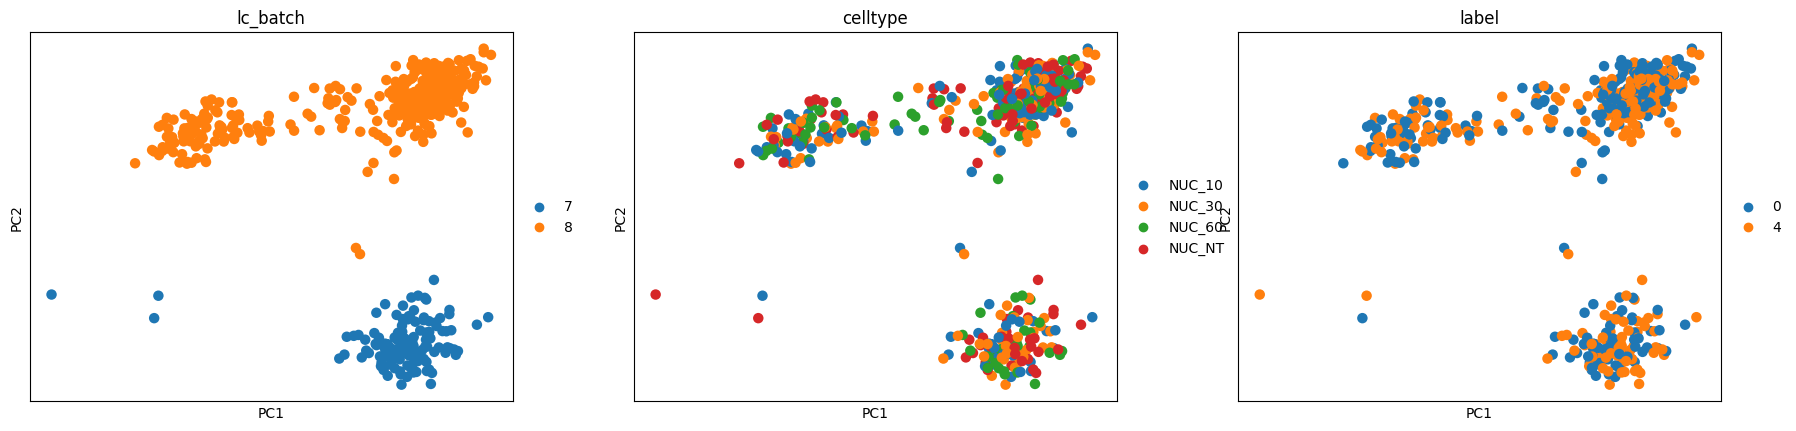

In [16]:
sc.pl.pca(adata, color=["lc_batch", "celltype", "label"])